# Importation of the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

# Importation of the dataset

In [2]:
#  Loading of the dataset from a CSV file
data=pd.read_csv("creditcard_2023.csv")

# Deleting "id" columns
data=data.drop(columns="id")

# Display the data to verify the changes
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,-1.161847,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,-0.210817,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,-0.144495,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,-0.080078,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


# Implementation of the necessary pre-processing

In [3]:
# Identifying the target variable for the correlation
corr_with_target = data.corr()['Class']

# Identifying the coluns we need to delete (columns with a correlation < 0.15 or > -0;15 with 'Class')
cols_to_drop = corr_with_target[(corr_with_target > -0.15) & (corr_with_target < 0.15)].index

# Keeping the column Amount for final analysis even if correlation is low
cols_to_drop = [col for col in cols_to_drop if col != 'Amount']

# Deleting the columns weekly correlated with 'Class'
df = data.drop(columns=cols_to_drop)

# Displaying de removed columns and the new dimensions of the dataset
print("Removed variables :", list(cols_to_drop))
print("New dimensions of the dataset :", df.shape)


Removed variables : ['V8', 'V13', 'V15', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V28']
New dimensions of the dataset : (568630, 20)


In [4]:
# Deleting the lines where target variable 'Class' is missing
df.dropna(subset=['Class'], inplace=True)

# Separation of the target variable (y) and explenatory variables (X)
y = df["Class"].astype(int)
X = df.drop(columns=["Class"]).copy()

# Separation of the data in training and testing sets (20% for the test, 80% for the train)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y,shuffle = True
)

# Standardization of explanatory variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Displaying the shapes of the sets to verify the separation
print("Shapes : ",
      "\n -> X_train :", X_train.shape,
      "\n -> X_test:", X_test.shape,
      "\n -> y_train:", y_train.shape,
      "\n -> y_test:", y_test.shape)

Shapes :  
 -> X_train : (454904, 19) 
 -> X_test: (113726, 19) 
 -> y_train: (454904,) 
 -> y_test: (113726,)


# Formalization of the problem

The problem studied is a supervised binary classification task aiming to distinguish fraudulent transactions from normal ones.
The target variable is Class, and the explanatory features are the components V1 to V28, along with Amount, which represents the transaction amount.

To evaluate the models, we use several metrics: accuracy, precision, recall, F1-score and AUC

In this context, a false positive means a normal transaction is wrongly flagged as fraud, which can inconvenience the user.
A false negative, on the other hand, is a fraud that goes undetected, leading to a direct financial loss.

Therefore, recall is the most important metric, as it measures the model’s ability to detect as many fraudulent cases as possible, even if it means producing a few false alerts. The F1-score and AUC are also useful to balance precision and detection.

# Selection of a baseline model and implementation of the model


=== Logistic Regression ===
Accuracy : 0.9639660236005838

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726



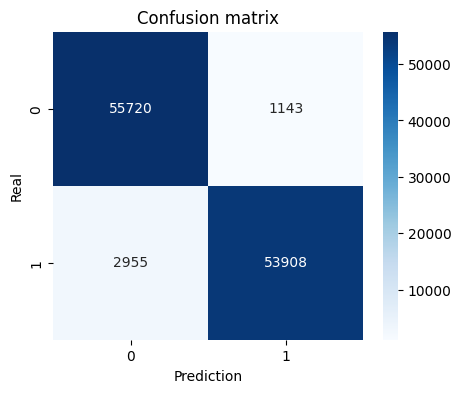

In [5]:
# Logistic Regression

# Creation of the Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, random_state=42)

# Training the model on the training data
model_lr.fit(X_train, y_train)

# Prediction on the test set
y_pred_lr = model_lr.predict(X_test)

# Predicted pobabilities for the positive class (1)
y_prob_lr = model_lr.predict_proba(X_test)[:,1]

# Displaying the results
print("=== Logistic Regression ===")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("\nClassification report :\n", classification_report(y_test, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()

# Testing other models

=== K-Nearest Neighbors ===
Accuracy: 0.9966938079243093
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.99      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



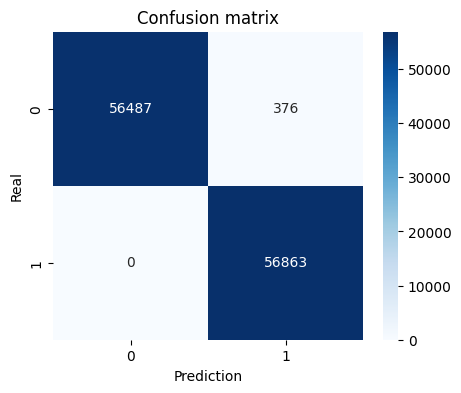

In [6]:
# K-Nearest Neighbors

# Creation of the KNN model with 5 neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)

# Training the model on the training data
model_knn.fit(X_train, y_train)

# Prediction on the test set
y_pred_knn = model_knn.predict(X_test)

# Predicted pobabilities for the positive class (1)
y_prob_knn = model_knn.predict_proba(X_test)[:,1]

# Displaying the results
print("=== K-Nearest Neighbors ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()

=== Decision Tree ===
Accuracy: 0.9975115628792008
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



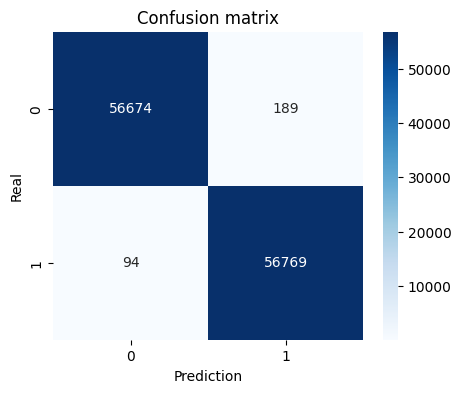

In [7]:
# Decision Tree

# Creating the DecisionTree model
model_dt = DecisionTreeClassifier(random_state=42)

# Training the model on the training data
model_dt.fit(X_train, y_train)

# Prediction on the test set
y_pred_dt = model_dt.predict(X_test)

# Predicted pobabilities for the positive class (1)
y_prob_dt = model_dt.predict_proba(X_test)[:,1]

# Displaying the results
print("=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()


=== XGBoost Classifier ===
Accuracy: 0.9944427835323497
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.99      1.00      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



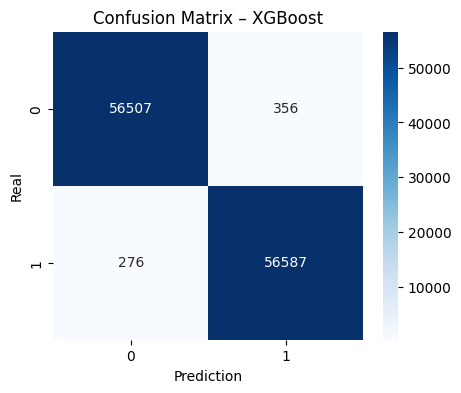

In [8]:
# XGBoost

# Creating the XGBoost model with the hyperparameters
model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

# Training the model on the training data
model_xgb.fit(X_train, y_train)

# Prediction on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Predicted pobabilities for the positive class (1)
y_prob_xgb = model_xgb.predict_proba(X_test)[:,1]

# Displaying the results
print("=== XGBoost Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix – XGBoost")
plt.show()

[LightGBM] [Info] Number of positive: 227452, number of negative: 227452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== LightGBM Classifier ===
Accuracy: 0.9973005293424547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



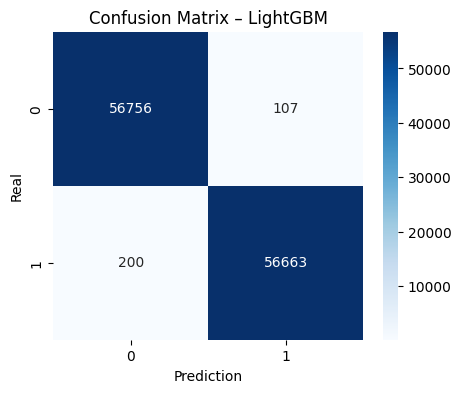

In [9]:
#LightGBM

# Creating the LightGBM model
model_lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,        # -1 = no depth limit
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    n_jobs=-1,
    random_state=42
)

# Training the model on the training data
model_lgbm.fit(X_train, y_train)

# Prediction on the test set
y_pred_lgbm = model_lgbm.predict(X_test)

# Predicted pobabilities for the positive class (1)
y_prob_lgbm = model_lgbm.predict_proba(X_test)[:,1]

# Displaying the results
print("=== LightGBM Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgbm)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix – LightGBM")
plt.show()

=== Polynomial Regression ===
Accuracy: 0.9871445403865431
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



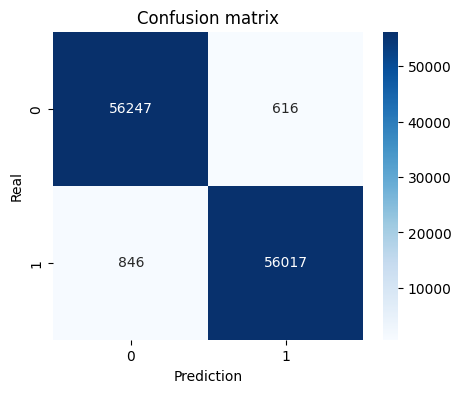

In [11]:
# Polynomial Regression

# Creation of a pipeline that generates polynomial features and then applies a logistic regression
model_pr = make_pipeline(
    PolynomialFeatures(degree=2),
    LogisticRegression(max_iter=1000) # Classification model
    )

# Training the model on the training data
model_pr.fit(X_train, y_train)

# Prediction on the test set
y_pred_poly = model_pr.predict(X_test)

# Predicted pobabilities for the positive class (1)
y_prob_poly = model_pr.predict_proba(X_test)[:,1]

# Displaying the results
print("=== Polynomial Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_poly)

# Displaying the confusion matrix like a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion matrix")
plt.show()


# What model will we chose

We will continue with XGBoost and LightGBM.
XGBoost is the best compromise between performance speed and stability. It stays precise even with a huge amount of data. It is a standard model for fraud detection.

For LightGBM it is even quicker than XGBoost and performs the same way so it could be even better for us with a dataset of 568k lines

# Evaluation metrics

In [12]:
print("=== XGBoost ===")

# Accuray : total proportion of good predictions
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))

# Classification report : precision, recall, f1-score
print("\nClassification report :\n", classification_report(y_test, y_pred_xgb))

# ROC-AUC : model's capacity to distinguish classes (based on the probabilities)
print("ROC AUC :", roc_auc_score(y_test, y_prob_xgb))

# Mean Asolut Error between y_test and y_pred
print("MAE  : ", mean_absolute_error(y_test, y_pred_xgb))

# Mean Squared Error
print("MSE  : ", mean_squared_error(y_test, y_pred_xgb))

# Square root of MSE
print("RMSE : ", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

# Coefficient of determination
print("R²   : ", r2_score(y_test, y_pred_xgb))


=== XGBoost ===
Accuracy : 0.9944427835323497

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.99      1.00      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

ROC AUC : 0.9997964519256908
MAE  :  0.005557216467650317
MSE  :  0.005557216467650317
RMSE :  0.074546740154418
R²   :  0.9777711341293988


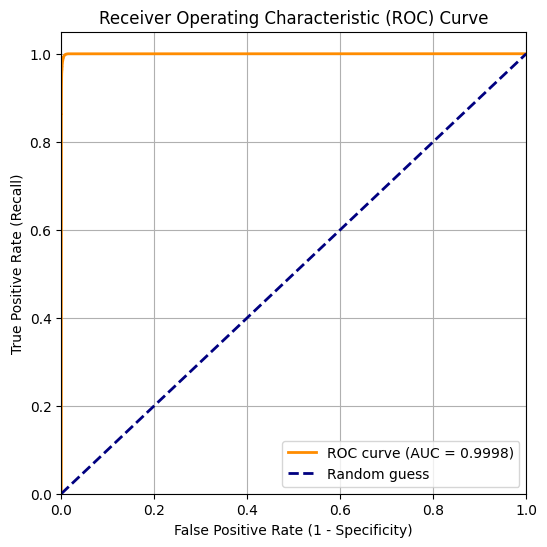

In [13]:
 # Calculation of the False Positive Rates (fpr), True Positive rates (tpr), and the assiocated thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)

# Area under the ROC curve
roc_auc = roc_auc_score(y_test, y_prob_xgb)

# Displaying the curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [14]:
print("=== LightGBM ===")

# Accuray : total proportion of good predictions
print("Accuracy :", accuracy_score(y_test, y_pred_lgbm))

# Classification report : precision, recall, f1-score
print("\nClassification report :\n", classification_report(y_test, y_pred_lgbm))

# ROC-AUC : model's capacity to distinguish classes (based on the probabilities)
print("ROC AUC :", roc_auc_score(y_test, y_prob_lgbm))

# Mean Asolut Error between y_test and y_pred
print("MAE  : ", mean_absolute_error(y_test, y_pred_lgbm))

# Mean Squared Error
print("MSE  : ", mean_squared_error(y_test, y_pred_lgbm))

# Square root of MSE
print("RMSE : ", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))

# Coefficient of determination
print("R²   : ", r2_score(y_test, y_pred_lgbm))


=== LightGBM ===
Accuracy : 0.9973005293424547

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

ROC AUC : 0.9963395100559526
MAE  :  0.0026994706575453283
MSE  :  0.0026994706575453283
RMSE :  0.05195643037724328
R²   :  0.9892021173698187


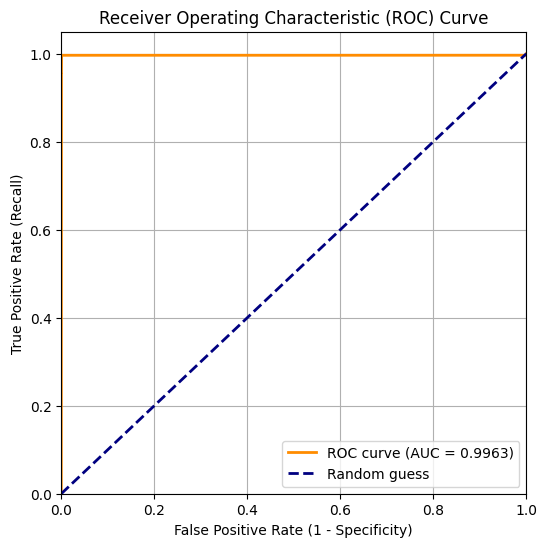

In [15]:
 # Calculation of the False Positive Rates (fpr), True Positive rates (tpr), and the assiocated thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lgbm)

# Area under the ROC curve
roc_auc = roc_auc_score(y_test, y_prob_lgbm)

# Displaying the curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Grid Search

In [16]:
# XGBoost

# Creating the XGBoost model for a binary classification problem
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

# Defining the research space to optimize the hyperparameters
param_dist_xgb = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.5, 1.0]
}

# Randomm research of hyperparameters
grid_xgb = RandomizedSearchCV(
    estimator=xgb_clf,                      # model to optimize
    param_distributions=param_dist_xgb,
    n_iter=20,                              # number of combinations tested
    scoring="f1",                           # metric to optimize
    cv=3,                                   # cross validation with 3 folds
    n_jobs=-1,
    verbose=1,                              # progression
    random_state=42
)

# Launching the optimization on the training data
grid_xgb.fit(X_train, y_train)

# Displaying the best hyperparameters found
print("\nBest XGBoost params :", grid_xgb.best_params_)
print("Best XGBoost CV F1  :", grid_xgb.best_score_)

# Extracting the best and optimized model
best_xgb = grid_xgb.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best XGBoost params : {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best XGBoost CV F1  : 0.9994617163755235


In [17]:
# 2) LightGBM

# Creating the base model (LGBM here)
lgbm_clf = LGBMClassifier(
    objective="binary",
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    force_row_wise=True
)

# Defining the research space to optimize the hyperparameters
param_dist_lgbm = {
    "n_estimators": [100, 200, 400],
    "max_depth": [-1, 3, 5, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "num_leaves": [15, 31, 63]
}

# Randomm research of hyperparameters
grid_lgbm = RandomizedSearchCV(
    estimator=lgbm_clf,                       # model to otpimize
    param_distributions=param_dist_lgbm,
    n_iter=20,                                # number of combinations tested
    scoring="f1",                             # metric to optimize
    cv=3,                                     # cross validation with 3 folds
    n_jobs=-1,
    verbose=1,                                # progression
    random_state=42
)

# Launching the optimization on the training data
grid_lgbm.fit(X_train, y_train)

# Displaying the best hyperparameters found
print("\nBest LightGBM params :", grid_lgbm.best_params_)
print("Best LightGBM CV F1  :", grid_lgbm.best_score_)

# Extracting the best and optimized model
best_lgbm = grid_lgbm.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best LightGBM params : {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best LightGBM CV F1  : 0.9992311185380708


In [18]:
# Function to evaluate a ML model
def evaluate_model(name, model, X_test, y_test):
    # Prediction of the classes
    y_pred = model.predict(X_test)
    # If the model has 'predict_proba' we calculate the AUC, if not we put AUC = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]    # Probability to be in the positive class
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None

    # Calculating the most important metrics
    acc = accuracy_score(y_test, y_pred)                        # Good predictions rate
    prec = precision_score(y_test, y_pred, zero_division=0)     # Precision
    rec = recall_score(y_test, y_pred, zero_division=0)         # Recall
    f1 = f1_score(y_test, y_pred, zero_division=0)              # f1-score

    # Displaying those metrics
    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC  : {auc:.4f}")

    # Keeping the results, to create a comparison table for the results
    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

results = []
results.append(evaluate_model("XGBoost (RS)",       grid_xgb.best_estimator_,  X_test, y_test))
results.append(evaluate_model("LightGBM (RS)",      grid_lgbm.best_estimator_, X_test, y_test))



=== XGBoost (RS) ===
Accuracy : 0.9995
Precision: 0.9989
Recall   : 1.0000
F1-score : 0.9995
ROC AUC  : 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LightGBM (RS) ===
Accuracy : 0.9987
Precision: 0.9980
Recall   : 0.9995
F1-score : 0.9987
ROC AUC  : 0.9994


## Voting classifier

In [19]:
# Voting classifier using the 2 best optimized models (XGB and LGBM)

# Creating the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ("xgb",   grid_xgb.best_estimator_),    # XGBoost optimized model
        ("lgbm",  grid_lgbm.best_estimator_)    #LightGBM oprimized model
    ],
    voting="soft"   # 'soft' = mean of the porbabilities, best for an unbalanced dataset
)

# Training of the Voting Classifier on the training data
voting_clf.fit(X_train, y_train)

# Evaluating the model and add to results
results.append(evaluate_model("Voting (XGB + LGBM)", voting_clf, X_test, y_test))

# Creating a summary table of the performances
results_df = pd.DataFrame(results)

# Displaying the final DataFrame
results_df

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Voting (XGB + LGBM) ===
Accuracy : 0.9991
Precision: 0.9987
Recall   : 0.9996
F1-score : 0.9991
ROC AUC  : 1.0000


,model,accuracy,precision,recall,f1,auc
0,XGBoost (RS),0.999464,0.998928,1.000000,0.999464,0.999979
1,LightGBM (RS),0.998725,0.997998,0.999455,0.998726,0.999357
2,Voting (XGB + LGBM),0.999129,0.998700,0.999560,0.999130,0.999970
